In [106]:
import pandas as pd
from ENV import *
import gym
from gym import spaces
import numpy as np
import warnings
import torch
from Functions import *
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_debug = None
_debug_count = 0

from stable_baselines3 import PPO, DQN, A2C, DDPG, TD3
from sb3_contrib import ARS, TQC, QRDQN, MaskablePPO, TRPO, RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback
import pickle, random
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import TensorBoardOutputFormat

# Suppress FutureWarning and UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# DISCRETE: ars a2c dqn ppo qrdqn rppo trpo mppo
# CONTINVS: ars a2c ddpg ppo rppo sac td3 tqc trpo
# RPPO is slow
algorithm_name = 'dqn'
space_mode = 'discrete'
policy = "MlpPolicy"

LEVERAGE = 1
TEST = 'long'
dataset_train = 'bnb21'
dataset_test = 'bnb22'

def loadDataSource():
  global TRAINING_DIVISOR
  if TEST == 'short':
    data_source = f'../data/{dataset_train}-short.csv'
    TRAINING_DIVISOR = 2
  elif TEST == 'long':
    data_source = f'../data/{dataset_train}-long.csv'
    TRAINING_DIVISOR = 50
  else:
    data_source = f'../data/{dataset_train}-full.csv'
    TRAINING_DIVISOR = 100
  return data_source

data_source = loadDataSource()
try:
  df = pd.read_csv(data_source)
except:
  dat = ((pd.read_csv(f'../data/{dataset_train}.csv',sep=',')).sort_values('date')[['date','open','high','low','close','volume']]).set_index('date')
  getStationary(dat, dataset_train, True)
  data_source = loadDataSource()
  df = pd.read_csv(data_source)


Reward for Profit: Encourage the agent to maximize profit. This could be based on the change in profit from the last action to the current action.

Penalty for Drawdown: Penalize the agent for high drawdowns to encourage it to avoid excessive risk. Drawdown is the measure from the highest point of equity to the lowest point thereafter.

Encouragement for Outperforming Buy-and-Hold: Reward the agent if it outperforms a simple buy-and-hold strategy. This could be based on the difference in profit between the agent's strategy and a buy-and-hold strategy.



In [107]:
def getReward(env_, type_):

  # # Calculate relative positions of MAs
  # ma_positions = [ma10, ma20, ma50]
  # ma_positions.sort()  # Sort MA values

  # # Calculate MA trend score (0 to 1)
  # ma_trend_score = (ma_positions.index(ma10) * 0.5 + ma_positions.index(ma20) * 0.3 + ma_positions.index(ma50) * 0.2) / 2.0

  # # Calculate price position relative to MAs
  # price_position = (current_price - ma10) / (ma50 - ma10)  # Assuming price is between MA10 and MA50

  # # Criteria for a long position
  # if open_position == 'long':
  #     # Calculate reward based on MA trend score and price position
  #     reward = (1.0 - ma_trend_score) * (1.0 - abs(price_position))

  # # Criteria for a short position
  # elif open_position == 'short':
  #     # Calculate reward based on MA trend score and price position
  #     reward = ma_trend_score * (1.0 - abs(price_position))
      
  if type_ in ['long', 'short']:
    _current_step = env_.current_step
    _df = env_.df
    ema_d = {f'EMA_{ma}' : _df[f'EMA_{ma}'].iloc[_current_step] for ma in EMA}
    ema_sorted = list(ema_d.values())
    ema_sorted.sort()
    ema_vals = [ema_d[f'EMA_{EMA[i]}'] for i in range(len(EMA))]
    # Calculate MA trend score (0 to 1)
    ma_trend_score = (ema_sorted.index(ema_vals[0]) * 0.5 + ema_sorted.index(ema_vals[1]) * 0.3 + ema_sorted.index(ema_vals[2]) * 0.2)
    # Calculate price position relative to MAs
    price_position = (1 - ema_vals[0]) / (ema_vals[2] - ema_vals[0])  # Assuming price (1) is between MA10 and MA50
    REWARD_MULTIPLIER = 4
    if type_ == 'long':
      # Calculate reward based on MA trend score and price position
      reward = REWARD_MULTIPLIER * (1.0 - ma_trend_score) * (1.0 - abs(price_position))
    elif type_ == 'short':
      reward = REWARD_MULTIPLIER * ma_trend_score * (1.0 - abs(price_position))
    return reward
  if type_ == 'illegal':
    return -0.1
  elif type_ == 'close':
    # CHANGE TO: PROFIT FROM THIS ONLY PARTICULAR TRADE
    # ALSO CONSIDER MDD        profit = 0
        # if self.portfolio['long'] > 0:
        #   profit = self.portfolio['long'] * (current_price - self.contract_price['long'])
        # elif self.portfolio['short'] > 0:
        #   profit = self.portfolio['short'] * (-current_price + self.contract_price['short'])

    delta_portfolio = env_.net_worth / INITIAL_ACCOUNT_BALANCE - 1
    delta_benchmark = env_.current_price / env_.initial_price * (1 - TRADING_FEE_CLOSE) - 1
    REWARD_FACTOR = 8
    return REWARD_FACTOR * (3 * delta_benchmark + delta_portfolio)
    # return 1
  elif type_ == 'hold':
    # delta_portfolio = env_.net_worth / INITIAL_ACCOUNT_BALANCE - 1
    # delta_benchmark = env_.current_price / env_.initial_price * (1 - TRADING_FEE_CLOSE) - 1
    # REWARD_FACTOR = 0.1
    # return REWARD_FACTOR * (3 * delta_benchmark + delta_portfolio) - 0.01
    return -0.1

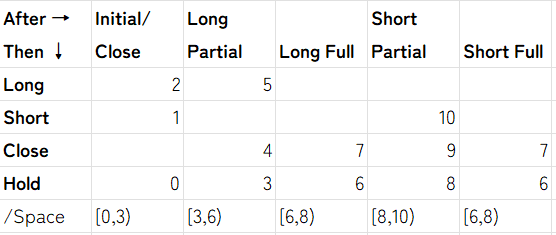

In [108]:
# Action Spaces
action_space_discrete = {
  'initial':  {'space': spaces.Discrete(3), 'offset': 0},
  'open':     {'space': spaces.Discrete(2), 'offset': 6},
}

action_space_continuous = {
  # array[0] ACTIONS
  # array[1] AMOUNT - portion of portfolio, max is 1
  # array[3] SET_TP - later
  # array[4] SET_SL - later
  'initial':       {'space': spaces.Box(low=np.array([0,0]), high=np.array([3,1]), dtype=np.float16), 'offset': 0},
  'open':          {'space': spaces.Box(low=np.array([6,0]), high=np.array([8,1]), dtype=np.float16), 'offset': 0},
  'long_partial':  {'space': spaces.Box(low=np.array([3,0]), high=np.array([6,1]), dtype=np.float16), 'offset': 0},
  'short_partial': {'space': spaces.Box(low=np.array([8,0]), high=np.array([11,1]), dtype=np.float16), 'offset': 0},
}

def isBalanceEnough(balance):
  return balance * (1 - TRADING_FEE_OPEN) < MINIMUM_TRANSACTION_DOLLAR

def translateAction(action_num):
  action_floored = math.floor(action_num)
  if action_floored in [0, 3, 6, 8]:
    action = 'hold'
  elif action_floored in [4, 7, 9]:
    action = 'close'
  elif action_floored in [2, 5]:
    action = 'long'
  elif action_floored in [1, 10]:
    action = 'short'
  return action

In [109]:
class TradingEnvironment(gym.Env):
  # metadata = {'render.modes': ['human']}

  def __init__(self, df, algorithm_name, space_mode, evaluate=False):
    super().__init__()

    self.df = df
    self.df['return'] = 0
    self.df['mdd'] = 0
    self.df = add_ema(self.df, True)

    # print(self.df)

    self.initial_price = df['close'].iloc[0]
    
    self.algorithm_name = algorithm_name
    self.space_mode = space_mode # discrete or continuous

    # ACTION space
    self.action_space_mode = 'initial'
    if self.space_mode == 'discrete':
      self.action_space = action_space_discrete['initial']['space']
      self.action_space_offset = action_space_discrete['initial']['offset']
    else:
      self.action_space = action_space_continuous['initial']['space']
      self.action_space_offset = action_space_continuous['initial']['offset']

    # OBSERVATION space
    if self.space_mode == 'discrete':
      # ×××××××××× CANCEL [0] CLOSE - last close in value in log USDT
      # [1] VOLUME - in log
      # [2] DELTA - close / open in portion
      # [3] AMPLITUDE - high / low in portion
      # [4] CLOSE_OVER_LOW close / low in portion
      # [5] ema1 over close
      # [6] ema2 over close
      # [7] ema3 over close
      # [8] profit movement in log ee8 (current_balance/inital_balance)
      # [9] benchmark movement ee8 (benchmark_price/initial_price)
      # ---------------------------------------------------------------------------------------------------------------SHOULD ALSO OBSERVE CURRENT POSITIONS
      # pa = -10 # _price_minimum 10^-10 USDT
      # pb = 10  # _price_maximum 10^10 USDT
      dr = 1 # minimum movement/volume, scaled into [-1, 1]
      ADDITIONAL_FEATURES = len(['profit_movement', 'benchmark_movement'])
      self.observation_space = spaces.Box(
        #                1   2   3   4   5   6   7   8   9
        low= np.array([-dr,-dr,-dr,-dr,-dr,-dr,-dr,-dr,-dr] * WINDOW_SIZE), 
        high=np.array([ dr, dr, dr, dr, dr, dr, dr, dr, dr] * WINDOW_SIZE),
        shape=(WINDOW_SIZE * (LEN_FEATURES + ADDITIONAL_FEATURES),),
        dtype=np.float16
      )
    else:
      pass #continuous

    self.current_step = 0
    
    # Balances
    self.balance = INITIAL_ACCOUNT_BALANCE 
    self.net_worth = INITIAL_ACCOUNT_BALANCE
    self.max_net_worth = INITIAL_ACCOUNT_BALANCE 
    self.min_net_worth = INITIAL_ACCOUNT_BALANCE 
    self.mdd_base = INITIAL_ACCOUNT_BALANCE
    self.mdd = 0
    self.mdd_last_sell = 0 # MDD at last sell
    
    # Stats
    self.transactions_count = {'long': 0, 'short': 0}
    self.transaction_fees = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_volume = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_usd_volume = {'long': 0, 'short': 0, 'close': 0}
    self.portfolio = {'long': 0, 'short': 0}
    self.contract_price = {'long': 0, 'short': 0}

    # Rewards
    self.current_reward = 0
    self.total_reward = 0

    # Modes
    self.EVALUATE_MODE = evaluate

    # Statistics for Debug
    self._last_action = 'hold'

  def _next_observation(self):
    # Get data points for the last WINDOW_SIZE
    frame_start = self.current_step
    frame_end = frame_start + WINDOW_SIZE - 1
    step = self.current_step
    try: 
      current_price = self.df.loc[step, "close"]
    except:
      current_price = self.df.loc[step - 1, "close"]

    obs = np.array([])
    for ft in FEATURES:
      _sliced_data = self.df.loc[frame_start:frame_end, ft]
      # _sliced_data_log = _sliced_data
      # if ft in ['close', 'volume']:
      #   _sliced_data_log = np.array([np.log(x) for x in np.nan_to_num(_sliced_data, nan=1)])
      obs = np.append(obs, _sliced_data)
    # Add PROFIT MOVEMENT and BENCHMARK MOVEMENT
    obs = np.append(obs, [
      np.log(self.net_worth / INITIAL_ACCOUNT_BALANCE) / np.log(10 ** 8), 
      np.log(current_price / self.initial_price) / np.log(10 ** 8)
    ])
    # obs = np.append(frame, [
    #   np.log(self.balance), 
    #   np.log(self.max_net_worth),
    # ], axis=0)

    if len(obs) < WINDOW_SIZE * LEN_FEATURES:
      obs = np.pad(obs, (0, WINDOW_SIZE * LEN_FEATURES - len(obs)), mode='constant', constant_values=1)
    # print(self.current_step, obs)
    return obs
  
  def updatePortoValues(self):
    step = self.current_step
    current_price = self.df.loc[step, "close"]
    contract_value_long = self.portfolio['long'] * current_price
    contract_value_short = self.portfolio['short'] * current_price
    # print(self.balance, self.contract_price['short'], self.contract_price['long'], contract_value_long, contract_value_long, 'NW:', self.net_worth, '\n')
    self.net_worth = self.balance + contract_value_long + contract_value_short

    self.max_net_worth = max(self.max_net_worth, self.net_worth)
    if self.net_worth > self.max_net_worth:
      self.mdd_base = self.max_net_worth # set mdd base higher
    else:
      self.mdd_base = min(self.mdd_base, self.net_worth)

    self.min_net_worth = min(self.min_net_worth, self.net_worth)
    self.mdd = max(1 - self.net_worth/self.max_net_worth, self.mdd)
    self.df.loc[step, 'mdd'] = self.mdd
    self.df.loc[step, 'return'] = (self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE




  def handleTakeActionDiscrete(self, action):
    # ------------------------------------------------------------------------- CHANGE SELF.CURRENT_ACTION_TYPE IF FAILED
    step = self.current_step
    current_price = self.df.loc[step, "close"]
    self.current_price = current_price
    self.current_action_type = translateAction(action + self.action_space_offset)

    try:
      self.df.loc[step - 1, 'position']
    except:
      self.current_action_type = 'hold'

    _debug_original_action = self.current_action_type
    force_hold = False
    
    # OPEN: LONG/SHORT: if has asset more than trx dollar ===============================================================================================================================
    if (self.current_action_type in ['long', 'short']):
      if self.balance >= MINIMUM_TRANSACTION_DOLLAR and self.portfolio['long'] == 0 and self.portfolio['short'] == 0:
        units_opened = round(self.balance / (current_price * (1 + TRADING_FEE_OPEN)), PRECISION)
        total_cost = units_opened * current_price
        fees = units_opened * TRADING_FEE_OPEN

        self.balance = self.balance - total_cost - fees
        self.transaction_volume[self.current_action_type] += units_opened
        self.transaction_usd_volume[self.current_action_type] += total_cost
        self.transaction_fees[self.current_action_type] += fees
        self.transactions_count[self.current_action_type] += 1
        self.df.loc[step, 'action'] = f'{self.current_action_type} {units_opened:5f} @ {current_price}'

        # Update porto and return values
        # self.net_worth = self.balance + total_cost
        self.portfolio[self.current_action_type] = units_opened
        if step > 0:
          self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position'] + units_opened
        else: 
          self.df.loc[step, 'position'] = units_opened
        self.portfolio[self.current_action_type] = self.df.loc[step, 'position']
        self.contract_price[self.current_action_type] = current_price

        self.updatePortoValues()

        self.current_reward = getReward(self, self.current_action_type)
      else:
        force_hold = True
        self.current_reward = getReward(self, 'illegal')

    # CLOSE ============================================================================================================================================================================
    if self.current_action_type == 'close':
      if self.df.loc[step - 1, 'position'] * current_price >= MINIMUM_TRANSACTION_DOLLAR and step >= 0:
        units_closed = self.portfolio['long'] + self.portfolio['short']
        fees = units_closed * TRADING_FEE_CLOSE
        
        self.balance += units_closed * current_price - fees
        self.portfolio = {'long': 0, 'short': 0}
        try: 
          self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position'] - units_closed
        except:
          self.df.loc[step, 'position'] = 0

        self.transaction_volume[self.current_action_type] += units_closed
        self.transaction_usd_volume[self.current_action_type] += units_closed * current_price
        self.transaction_fees[self.current_action_type] += fees
        
        self.updatePortoValues()

        self.current_reward = getReward(self, 'close')
        
        self.df.loc[self.current_step, 'action'] = f'close {units_closed:5f} @ {current_price}'

      else:
        force_hold = True
        self.current_reward = getReward(self, 'illegal')

    # HOLD ============================================================================================================================================================================
    if force_hold or self.current_action_type == 'hold':
      self.updatePortoValues()
      try: 
        self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position']
      except:
        self.df.loc[step, 'position'] = 0
      self.df.loc[step, 'action'] = 'hold'

      delta_portfolio = self.net_worth / INITIAL_ACCOUNT_BALANCE - 1
      delta_benchmark = current_price / self.initial_price * (1 - TRADING_FEE_CLOSE) - 1
      REWARD_FACTOR = 0.1
      self.current_reward = REWARD_FACTOR * (3 * delta_benchmark + delta_portfolio) - 0.01

    # print(action, action_type, self.df.loc[self.current_step, 'position'], self.df.loc[self.current_step, 'action'], self.balance)
    # if step > 0:
    #   print(_debug_original_action, 'hold' if force_hold else self.current_action_type, 
    #         '| REASON: OPEN:', self.balance, '>', MINIMUM_TRANSACTION_DOLLAR, self.portfolio['long'], self.portfolio['short'],
    #         ' CLOSE: ', self.df.loc[step - 1, 'position'] * current_price, '>', MINIMUM_TRANSACTION_DOLLAR, step)
    
    self.df.loc[self.current_step, 'reward'] = self.current_reward
    self.total_reward += self.current_reward

  def handleTakeActionContinuous(self, action):
    current_price = self.df.loc[self.current_step, "close"]
    if action == 0 and self.balance > np.log(MINIMUM_TRANSACTION_DOLLAR):
      pass
    # SHORT
    if action == 1 and self.balance > np.log(MINIMUM_TRANSACTION_DOLLAR):
      pass
    # HOLD
    if action == 2:
      pass
    # CLOSE
    if action == 3:
      pass
  
  def step(self, action):
    # end_ = len(self.df) - WINDOW_SIZE - 1
    end_ = len(self.df)

    if self.space_mode == 'discrete':
      self.handleTakeActionDiscrete(action)
    else:
      self.handleTakeActionContinuous(action)

    self.current_step += 1
    obs = self._next_observation()

    ########################### DYNAMIC ACTION SPACE ////////////////////////////////////////////////////////////////////////////////////////////////////////
    if space_mode == 'discrete':
      portfolio_sellable = self.portfolio['short'] + self.portfolio['long'] > MINIMUM_TRANSACTION_DOLLAR / self.current_price
      if portfolio_sellable: # if has a position
        self.action_space = action_space_discrete['open']['space'] # change to close-hold only
        self.action_space_offset = action_space_discrete['open']['offset']
      else:
        self.action_space = action_space_discrete['initial']['space'] # can do anything
        self.action_space_offset = action_space_discrete['initial']['offset']
    else:
      pass

    global _debug
    if not _debug:
      _debug = {'2': 0, '3': 0, 'n': str(self.action_space)[-3:], 'in_porto': self.portfolio['long'] + self.portfolio['short']}
    if '2' in _debug['n']:
      _debug['2'] += 1
    elif '3' in _debug['n']:
      _debug['3'] += 1

    
    if self.EVALUATE_MODE:
      done = self.current_step == end_
    else:
      done = self.current_step == int(end_ / TRAINING_DIVISOR)
      # global _debug_count
      # _debug_count += 1
      # if _debug_count % 15 == 0:
      #   print(_debug, end=' ')
      #   print(self.transactions_count)
    # if (done):
    #   try:
    #     _closing_price = self.df.iloc[self.current_step]['close']
    #   except:
    #     _closing_price = self.df.iloc[self.current_step - 1]['close']
    #   print(f'-------{self.current_step:6d}\n', 
    #         'RW ',  f'{self.total_reward:7.0f}\n', 
    #         'MD ',  f'{self.mdd:.3f}\n', 
    #         'RET ', f'{((self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE): 2.3f}\n',
    #         'RVB ', f'{((self.net_worth - INITIAL_ACCOUNT_BALANCE) - _closing_price / self.initial_price):2.3f}\n',
    #         'FIN ', f'{INITIAL_ACCOUNT_BALANCE:7d} → {self.net_worth:7.0f}\n')

    return obs, self.current_reward, done, {}
  
  def reset(self):
    self.balance = INITIAL_ACCOUNT_BALANCE
    self.net_worth = INITIAL_ACCOUNT_BALANCE
    self.max_net_worth = INITIAL_ACCOUNT_BALANCE
    self.mdd_base = INITIAL_ACCOUNT_BALANCE
    self.min_net_worth = INITIAL_ACCOUNT_BALANCE
    self.mdd = 0
    self.mdd_last_sell = 0

    self.transactions_count = {'long': 0, 'short': 0}
    self.transaction_fees = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_volume = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_usd_volume = {'long': 0, 'short': 0, 'close': 0}
    self.portfolio = {'long': 0, 'short': 0}
    self.contract_price = {'long': 0, 'short': 0}

    self.total_reward = 0
    self.current_step = 0
    
    if self.space_mode == 'discrete':
      self.action_space = action_space_discrete['initial']['space']
    else:
      self.action_space = action_space_continuous['initial']['space']

    return self._next_observation()

  def render(self, mode='human', close=False):
    # Render the environment to the screen
    profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

    print(f'Step: {self.current_step}')
    print(f'Balance: {self.balance}')
    print(f'Transaction Volume: {self.transaction_volume}')
    print(f'Transaction USD Volume: {self.transaction_usd_volume}')
    print(f'Transaction Fees: {self.transaction_fees}')
    print(f'Transaction Count: {self.transactions_count}')
    
    print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth}, min: {self.min_net_worth})')
    print(f'MDD: {self.mdd}')
    print(f'Profit: {profit}')
    print()

In [110]:
class SummaryWriterCallback(BaseCallback):
    def __init__(self):
      super().__init__()

    def _on_training_start(self):
      self._log_freq = int(len(df) / TRAINING_DIVISOR)  # log every INTERVAL calls

      output_formats = self.logger.output_formats
      # Save reference to tensorboard formatter object
      # note: the failure case (not formatter found) is not handled here, should be done with try/except.
      self.tb_formatter = next(formatter for formatter in output_formats if isinstance(formatter, TensorBoardOutputFormat))

    def _on_step(self) -> bool:
      # Log my_custom_reward every _log_freq(th) to tensorboard for each environment
      if self.n_calls % self._log_freq == self._log_freq - 1:
        if algorithm_name in ['ars', 'tqc', 'qrdqn', 'mppo', 'trpo', 'rppo']:
          _vars_locals_env = vars(self.locals['self'])
          _vars_locals_env = vars(_vars_locals_env['env'])
        else:
          _vars_locals_env = vars(self.locals['env'])
        _vars_locals_env = vars(_vars_locals_env['envs'][0])
        _vars_locals_env = vars(_vars_locals_env['gym_env'])
        total_reward = _vars_locals_env['total_reward']
        mdd = _vars_locals_env['mdd']
        return_ = _vars_locals_env['net_worth'] / INITIAL_ACCOUNT_BALANCE
        transactions_count_long = _vars_locals_env['transactions_count']['long']
        transactions_count_short = _vars_locals_env['transactions_count']['short']
        # transaction_volume_long = _vars_locals_env['transaction_volume']['long']
        # transaction_volume_short = _vars_locals_env['transaction_volume']['short']
        # print(total_reward, mdd, return_)
      # rewards = self.locals['my_custom_info_dict']['my_custom_reward']
      # for i in range(self.locals['env'].num_envs):
        self.tb_formatter.writer.add_scalar("main/rewards", total_reward, self.n_calls)
        self.tb_formatter.writer.add_scalar("main/mdd", mdd, self.n_calls)
        self.tb_formatter.writer.add_scalar("main/return", return_, self.n_calls)
        self.tb_formatter.writer.add_scalar("trxs/count_long", transactions_count_long, self.n_calls)
        self.tb_formatter.writer.add_scalar("trxs/count_short", transactions_count_short, self.n_calls)
        # self.tb_formatter.writer.add_scalar("trxs/volume_long", transaction_volume_long, self.n_calls)
        # self.tb_formatter.writer.add_scalar("trxs/volume_short", transaction_volume_short, self.n_calls)
      return self.n_calls < len(df) * EPISODE

In [111]:
env = DummyVecEnv([lambda: TradingEnvironment(df, algorithm_name, space_mode)])
# check_env(env)
eval_callback = EvalCallback(env, 
                  best_model_save_path=f"./results/models_/{algorithm_name}_{space_mode}_best_model", 
                  log_path=f"./results/results_/{algorithm_name}_{space_mode}_res", 
                  eval_freq=len(df))
space_mode = space_mode
df = df

if algorithm_name == 'ppo':
  model = PPO(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'dqn':
  model = DQN(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'a2c':
  model = A2C(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'ddpg':
  model = DDPG(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'td3':
  model = TD3(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'ars':
  model = ARS(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'tqc':
  model = TQC(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'qrdqn':
  model = QRDQN(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'mppo':
  model = MaskablePPO(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'trpo':
  model = TRPO(policy, env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')
elif algorithm_name == 'rppo':
  model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, tensorboard_log=LOG_LOCATION, device='cpu')

def saveModel():
  # save best model
  model.save(f'./results/models_/model-{algorithm_name}-{space_mode}-{LEN_FEATURES}-{WINDOW_SIZE}-{random.randint(0,99)}')
  pickle.dump({'name': f'{algorithm_name}-{space_mode}', 'data': df}, open(f"'./results/models_/model-{algorithm_name}-{space_mode}-{LEN_FEATURES}-{WINDOW_SIZE}-{random.randint(0,99)}.pkl", 'ab'))

def plot(df=pd.DataFrame([]) ):
  if not df.empty:
    dff = df.head(len(df) - WINDOW_SIZE - 1)
    fig = make_subplots(rows=2, cols=1, specs = [[{"secondary_y": False}], [{"secondary_y": False}]])
    fig.update_layout(autosize=False, width=1300, height=800, title_text=f'{algorithm_name}-{space_mode}')
    initial_price = float(df.head(1)['close'])
    fig.append_trace(go.Scatter( x=dff.index, y=dff['close'] / initial_price, name='Benchmark', legendgroup='1', marker=dict(size=42, color='black')), row=1, col=1)
    # Portfolio
    fig.append_trace(go.Scatter(x=dff.index,y=dff['return'] + 1,name='Portfolio', marker=dict(size=42,color='red',)), row=1, col=1)
    # MDD
    fig.add_trace(go.Scatter(x=dff.index,y=-dff['mdd'],name='MDD',marker=dict(size=42,color='blue',)), row=2, col=1)
    return fig

def evaluate(data_addr, label):
    dat_te = pd.read_csv(data_addr)
    dat_te = dat_te.reset_index(level=0)

    env_te = DummyVecEnv([lambda: TradingEnvironment(dat_te, algorithm_name, space_mode, True)])

    obs_te = env_te.reset()

    for i in range(len(dat_te)):
      if algorithm_name in ['a2c', 'ppo']:
        action, _states = model.predict(obs_te)
      else:
        action, _states = model.predict(obs_te)
      obs_te, rewards, done, info = env_te.step(action)
      if (i + 1) % 500 == 0 or i == len(dat_te) - 1:
        env_te.render()
    
    fig = plot(dat_te)

      # f'./results/evaluation_/{self.algorithm_name}-{self.space_mode}-{label}-test') 
      # custom_range=[min(dat_te['return']), 
      #               max(dat_te['return'])])

    # res_ = {
    #     'name': f'{self.algorithm_name}-{self.space_mode}-{label}-test',
    #     'data': dat_te,
    #     'figure': fig
    # }

    return fig

Using cpu device


In [112]:
checkpoint_callback = CheckpointCallback(save_freq=len(df), save_path=f"./results/logs_/{algorithm_name}_{space_mode}_log")
summary_cb = SummaryWriterCallback()
callback = CallbackList([checkpoint_callback, summary_cb])
model.learn(total_timesteps=EPISODE * len(df), log_interval=INTERVAL, callback=callback)


Logging to ./results/logs_\DQN_2


In [113]:
# res = evaluate('../data/btc23clean.csv', 'btc23')
alter_test = False
evaluate(f'../data/{dataset_test}-{alter_test if alter_test else TEST}.csv', dataset_test)
